In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 6 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")

'hf/results/re-docred_facebook--dragon-plus-query-encoder_7170.pkl'

In [3]:
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [4]:
df = df_raw.copy()
df = df[df["head_entity_names"].str.len() > 1]
print(len(df))

df["head_entity_shortest_name"] = df["head_entity_names"].apply(lambda x: min(x, key=len))
df["query_long_name"] = df["query"]
df["query_short_name"] = df.apply(lambda r: r["query"].replace(r["head_entity_longest_name"], r["head_entity_shortest_name"]), axis=1)

def replace_heads(r, replacement):
    sents = r["sents"]
    head_all_pos = []
    head_start_pos = []
    for e in r["head_entity"]:
        if "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", "") != e["name"].replace(" ", ""):
            print("ERROR", e["name"].replace(" ", ""), " != ", "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", ""))
        head_start_pos.append((e["sent_id"], e["pos"][0]))
        for i in range(e["pos"][0], e["pos"][1]):
            head_all_pos.append((e["sent_id"], i))
        
    new_words = []
    for sent_id, sent in enumerate(sents):
        for wi, word in enumerate(sent):
            if (sent_id, wi) in head_start_pos:
                new_words.append(replacement)
            if (sent_id, wi) not in head_all_pos:
                new_words.append(word)
    return " ".join(new_words)
            

df["gold_doc_long_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_longest_name"]), axis=1)
df["gold_doc_short_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_shortest_name"]), axis=1)

df[["query", "query_long_name", "query_short_name", "gold_doc_long_name", "gold_doc_short_name"]].sample(5)

1878


ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR G.bipinnatifida  !=  G. bipinnatifida
ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR 8.
Hlawka  !=  Hlawka
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR 0.
TheSwingles  !=  TheSwingles
ERROR G.bipinnatifida  !=  G. bipinnatifida


,query,query_long_name,query_short_name,gold_doc_long_name,gold_doc_short_name
776,When did Thomas Marlow die?,When did Thomas Marlow die?,When did Marlow die?,"Thomas Marlow ( 15 December 1878 – 13 August 1954 ) was an English cricketer . Thomas Marlow was a left - handed batsman who bowled left - arm slow - medium . He was born at Anstey , Leicestershire . Thomas Marlow joined the Leicestershire ground staff...","Marlow ( 15 December 1878 – 13 August 1954 ) was an English cricketer . Marlow was a left - handed batsman who bowled left - arm slow - medium . He was born at Anstey , Leicestershire . Marlow joined the Leicestershire ground staff in 1898 , and initia..."
1,Who performed Loud Tour?,Who performed Loud Tour?,Who performed Loud?,"The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth studio album Loud Tour ( 201...","The Loud was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth studio album Loud ( 2010 ) . Crit..."
486,What genre does Bret Michaels belong to?,What genre does Bret Michaels belong to?,What genre does Michaels belong to?,""" Something to Believe In "" is a power ballad by American Glam metal band Poison , being the 2nd single from their 1990 album Flesh & Blood . "" Something to Believe In "" was also released on the Best of Ballads & Blues album in 2003 , with alternate ly...",""" Something to Believe In "" is a power ballad by American Glam metal band Poison , being the 2nd single from their 1990 album Flesh & Blood . "" Something to Believe In "" was also released on the Best of Ballads & Blues album in 2003 , with alternate ly..."
3698,Where was Paul Desmarais Jr. educated?,Where was Paul Desmarais Jr. educated?,Where was Paul Desmarais educated?,"Paul Desmarais Jr. ( born July 3 , 1954 ) is a Canadian businessman in his hometown of Montreal . He is the eldest son of Paul Desmarais Sr . and Jacqueline ( Maranger ) Desmarais . Currently he is the Chairman and Co - Chief Executive Officer of Power...","Paul Desmarais ( born July 3 , 1954 ) is a Canadian businessman in his hometown of Montreal . He is the eldest son of Paul Desmarais Sr . and Jacqueline ( Maranger ) Desmarais . Currently he is the Chairman and Co - Chief Executive Officer of Power Cor..."
252,"When was Maggie Simpson in "" The Longest Daycare "" published?","When was Maggie Simpson in "" The Longest Daycare "" published?",When was The Longest Daycare published?,"Maggie Simpson in "" The Longest Daycare "" , or simply Maggie Simpson in "" The Longest Daycare "" , is a 2012 American traditionally animated 3D comedy short film based on the animated television series The Simpsons . In the film , Maggie Simpson is enro...","The Longest Daycare , or simply The Longest Daycare , is a 2012 American traditionally animated 3D comedy short film based on the animated television series The Simpsons . In the film , Maggie Simpson is enrolled at a new daycare facility where she squ..."


In [5]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

  0%|          | 0/6 [00:00<?, ?it/s]

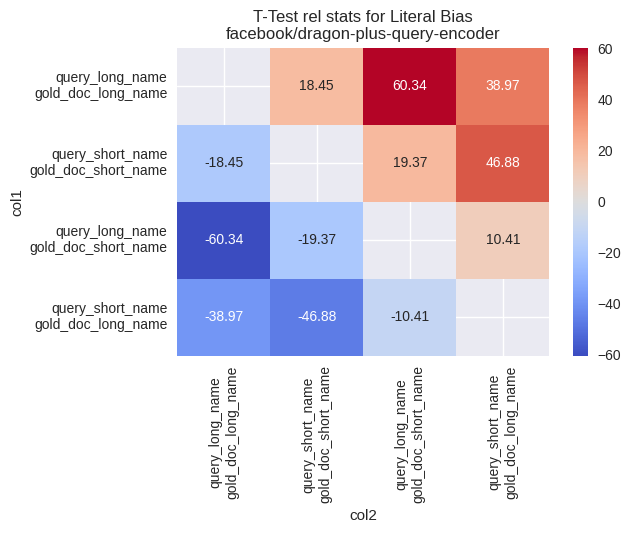

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


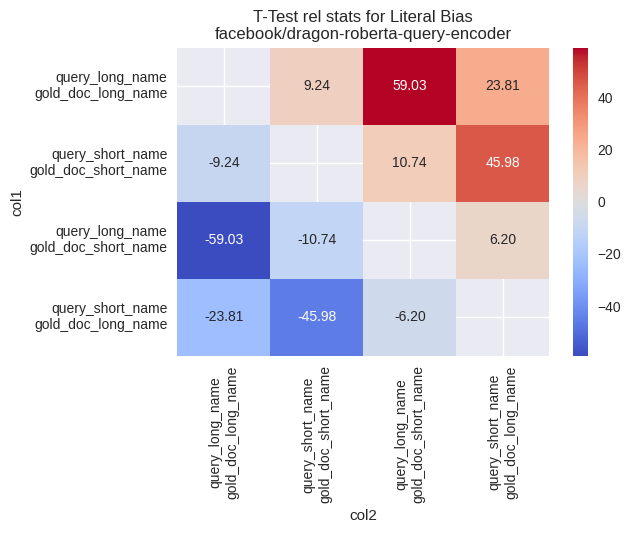

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


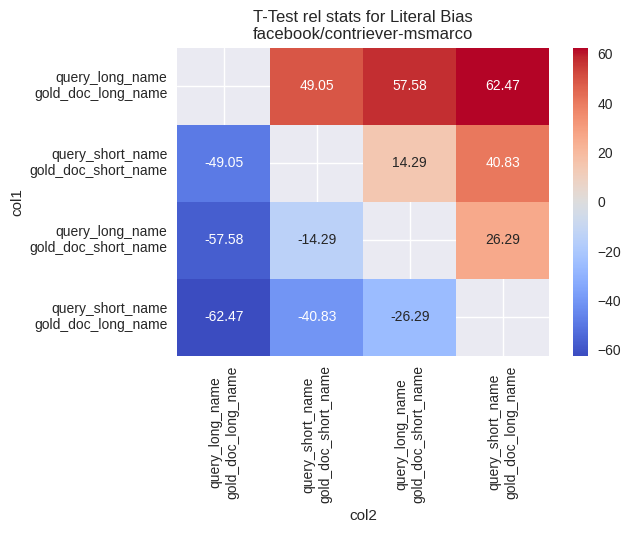

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


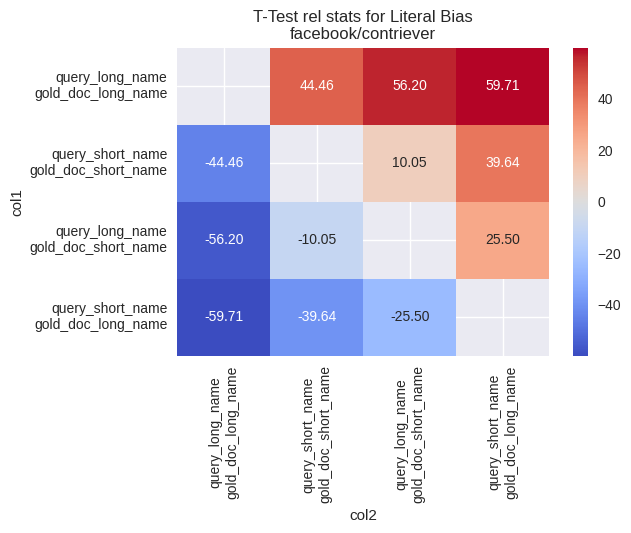

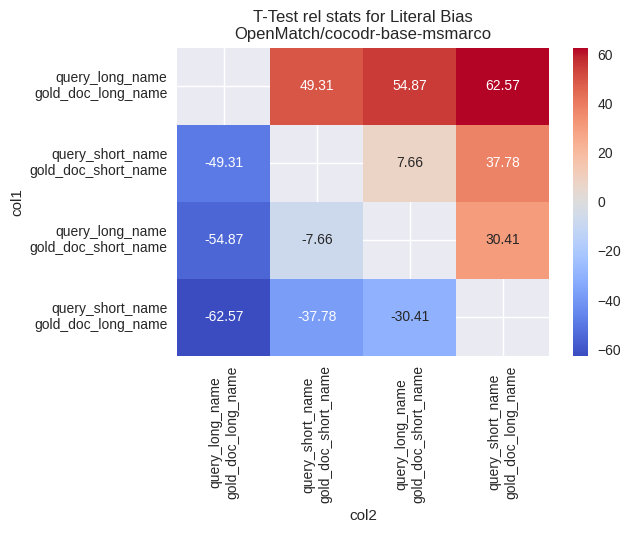

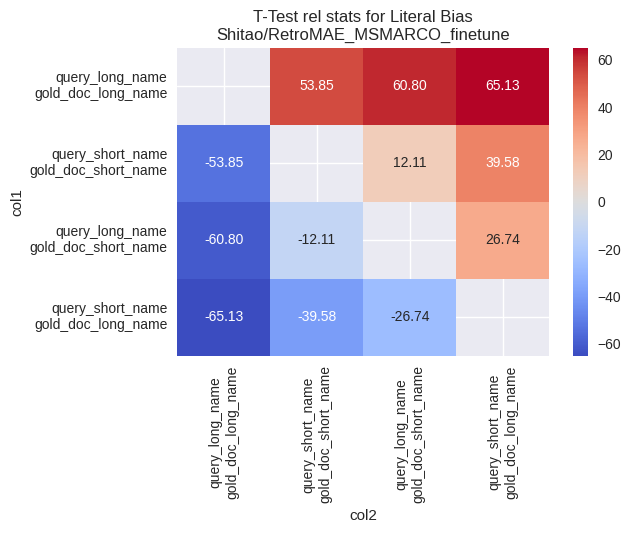

,query_model,col1,col2,ttest_stats,ttest_pvalue
0,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_long_name\ngold_doc_long_name,NaN,NaN
1,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_long_name,38.972224,6.201923e-244
2,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_long_name\ngold_doc_short_name,60.341980,0.000000e+00
3,facebook/dragon-plus-query-encoder,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_short_name,18.448446,5.655928e-70
4,facebook/dragon-plus-query-encoder,query_short_name\ngold_doc_long_name,query_long_name\ngold_doc_long_name,-38.972224,6.201923e-244
...,...,...,...,...,...
11,Shitao/RetroMAE_MSMARCO_finetune,query_long_name\ngold_doc_short_name,query_short_name\ngold_doc_short_name,-12.109367,1.489344e-32
12,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_long_name,-53.854675,0.000000e+00
13,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_short_name\ngold_doc_long_name,39.575500,1.382559e-249
14,Shitao/RetroMAE_MSMARCO_finetune,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_short_name,12.109367,1.489344e-32


In [6]:
cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]
query_cols = [
    # "query", 
    "query_long_name", "query_short_name"
]
doc_cols = [
    # "gold_doc_text", 
    "gold_doc_long_name", "gold_doc_short_name"
]

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    
    plot_col_dots = []
    
    for d_col in doc_cols:
        embds = dpr.encode_corpus(to_doc_format(df[d_col].to_list()))
        for q_col in query_cols:
            query_embds = dpr.encode_queries(df[q_col].to_list())
            embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds))
            new_col = f"{q_col}\n{d_col}"
            # print(new_col)
            df[new_col] = embds_dot.cpu().numpy()
            plot_col_dots.append(new_col)
    
    # df[plot_col_dots[::-1]].boxplot(figsize=(9, 5), rot=0, vert=False)
    # plt.title(f"{query_model}, support: {len(df)}")
    # plt.show()
    
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            rdf.append({
                "query_model": query_model,
                "col1": col1,
                "col2": col2,
                "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
            })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf])
    rdfp = rdf.pivot(index="col1", columns="col2", values="ttest_stats")
    order = [
        'query_long_name\ngold_doc_long_name', 
        'query_short_name\ngold_doc_short_name', 
        'query_long_name\ngold_doc_short_name',
        'query_short_name\ngold_doc_long_name',
    ]
    rdfp = rdfp.reindex(columns=order, level='col2')  # Sort columns
    rdfp = rdfp.reindex(order)
    plt.figure(figsize=(6, 4))
    sns.heatmap(rdfp, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"T-Test rel stats for Literal Bias\n{query_model}")
    plt.show()
    rdf
    

# results.append({
#     "query_model": query_model,
#     "context_model": context_model,
#     "POOLING": POOLING,
#     "support": len(df),
#     "query_type": q,
#     "sents_complete_w_end_dot_vs_wo": stats.ttest_rel(df["sents_complete_w_end_dot"], df["sents_complete_wo_end_dot"]),
#     "head_w_tail_dot_vs_wo": stats.ttest_rel(df["head_w_tail_dot"], df["head_wo_tail_dot"]),
#     "sents_complete_rm_wo_dot_vs_w": stats.ttest_rel(df["sents_complete_rm_head_wo_tail_dot"], df["sents_complete_rm_head_w_tail_dot"]),
# })
results_df

In [7]:
df = results_df.dropna().copy()

# df["col"] = df["col1"] + " vs " + df["col2"]

df["Query Name 1"] = df["col1"].apply(lambda x: x.split("\n")[0].split("_")[1])
df["Doc Name 1"] = df["col1"].apply(lambda x: x.split("\n")[1].split("_")[2])
df["Query Name 2"] = df["col2"].apply(lambda x: x.split("\n")[0].split("_")[1])
df["Doc Name 2"] = df["col2"].apply(lambda x: x.split("\n")[1].split("_")[2])
df = df[["query_model", "Query Name 1", "Doc Name 1", "Query Name 2", "Doc Name 2", "ttest_stats", "ttest_pvalue"]]
df = df[df["Query Name 1"] == df["Doc Name 1"]]
df = df[~((df["Query Name 2"] == "long") & (df["Doc Name 2"] == "long"))]
df = pd.pivot_table(
    df,
    values=[
        "ttest_stats", 
        # "ttest_pvalue",
    ],
    index=[
        "Query Name 1", "Doc Name 1", "Query Name 2", "Doc Name 2"
    ],
    columns=['query_model'], margins=False, aggfunc=lambda x: x.iloc[0] if len(x) == 1 else -100,
)

# LATEX
def clean_table(table_str):
    mappings = {
        "attention": "Attention",
    }
    model_mappings = {
        "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
        r"Shitao/RetroMAE\_MSMARCO\_finetune": ("RetroMAE", "MSMARCO FT"),
        r"Shitao/RetroMAE\_MSMARCO": ("RetroMAE", "MSMARCO"),
        "Shitao/RetroMAE": ("RetroMAE", ""),
        "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
        "facebook/contriever": ("Contriever", ""),
        "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
        "facebook/dragon-roberta-query-encoder": ("Dragon", "RoBERTa"),
    }
    back = "\\"
    raw_mappings = {
        # r"Method & Selection &  &  &  &  &  &  &  &  &  &  \\": "",
        r"query\_model": "Model",
        "llllrrrrrr": r"p{1.2cm}p{1.2cm}p{1.2cm}p{1.2cm}rrrrrr",
        r"\cline{1-10} \cline{2-10} \cline{3-10}": "\\midrule",
    }
    for k, v in mappings.items():
        key = k.replace('_', '\\_')
        table_str = table_str.replace("\\textbf{" + key + "}", "\\textsc{" + v + "}")
    for k, v in model_mappings.items():
        key = k
        value = r"\makecell{" + v[0] + r" \\ " + v[1] + r"}"
        table_str = table_str.replace(key, value)
    for k, v in raw_mappings.items():
        table_str = table_str.replace(k, v)
    return table_str
print(clean_table(df.round(2).to_latex(float_format="%.2f", bold_rows=True, ).replace("_", r"\_")))
# print(df.round(2).to_latex(float_format="%.2f", bold_rows=True, ).replace("_", "\_"))

df

\begin{tabular}{p{1.2cm}p{1.2cm}p{1.2cm}p{1.2cm}rrrrrr}
\toprule
 &  &  &  & \multicolumn{6}{r}{ttest\_stats} \\
 &  &  & Model & \makecell{COCO-DR \\ Base MSMARCO} & \makecell{RetroMAE \\ MSMARCO FT} & \makecell{Contriever \\ } & \makecell{Contriever \\ MSMARCO} & \makecell{Dragon+ \\ } & \makecell{Dragon \\ RoBERTa} \\
Query Name 1 & Doc Name 1 & Query Name 2 & Doc Name 2 &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{\textbf{long}} & \multirow[t]{3}{*}{\textbf{long}} & \textbf{long} & \textbf{short} & 54.87 & 60.80 & 56.20 & 57.58 & 60.34 & 59.03 \\
\cline{3-10}
\textbf{} & \textbf{} & \multirow[t]{2}{*}{\textbf{short}} & \textbf{long} & 62.57 & 65.13 & 59.71 & 62.47 & 38.97 & 23.81 \\
\textbf{} & \textbf{} & \textbf{} & \textbf{short} & 49.31 & 53.85 & 44.46 & 49.05 & 18.45 & 9.24 \\
\midrule
\multirow[t]{2}{*}{\textbf{short}} & \multirow[t]{2}{*}{\textbf{short}} & \textbf{long} & \textbf{short} & 7.66 & 12.11 & 10.05 & 14.29 & 19.37 & 10.74 \\
\cline{3-10}
\textbf{} & \textbf{} 

ttest_stats  \
query_model                                     OpenMatch/cocodr-base-msmarco   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                 
long         long       long         short                          54.871851   
                        short        long                           62.574783   
                                     short                          49.311297   
short        short      long         short                           7.658213   
                        short        long                           37.783262   

                                                                                  \
query_model                                     Shitao/RetroMAE_MSMARCO_finetune   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                    
long         long       long         short                             60.802600   
                        short        long                              65.127592   
                                     short                             53.854675   
short        short      long         short                             12.109367   
                        short        long                              39.575500   

                                                                     \
query_model                                     facebook/contriever   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                       
long         long       long         short                56.202790   
                        short        long                 59.709719   
                                     short                44.462108   
short        short      long         short                10.053285   
                        short        long                 39.642779   

                                                                             \
query_model                                     facebook/contriever-msmarco   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                               
long         long       long         short                        57.583470   
                        short        long                         62.473594   
                                     short                        49.046456   
short        short      long         short                        14.290332   
                        short        long                         40.828105   

                                                                                    \
query_model                                     facebook/dragon-plus-query-encoder   
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                      
long         long       long         short                               60.341980   
                        short        long                                38.972224   
                                     short                               18.448446   
short        short      long         short                               19.371967   
                        short        long                                46.879568   

                                                                                       
query_model                                     facebook/dragon-roberta-query-encoder  
Query Name 1 Doc Name 1 Query Name 2 Doc Name 2                                        
long         long       long         short                                  59.029981  
                        short        long                                   23.809490  
                                     short                                   9.244742  
short        short      long         short                                  10.742268  
                        short        long                                   45.976089

In [8]:
order = [
    'query_long_name\ngold_doc_long_name', 
    'query_short_name\ngold_doc_short_name', 
    'query_long_name\ngold_doc_short_name',
    'query_short_name\ngold_doc_long_name',
]
rdfp2 = rdfp.reindex(columns=order, level='col2')  # Sort columns
rdfp2 = rdfp2.reindex(order)
rdfp2

col2,query_long_name\ngold_doc_long_name,query_short_name\ngold_doc_short_name,query_long_name\ngold_doc_short_name,query_short_name\ngold_doc_long_name
col1,,,,
query_long_name\ngold_doc_long_name,NaN,53.854675,60.802600,65.127592
query_short_name\ngold_doc_short_name,-53.854675,NaN,12.109367,39.575500
query_long_name\ngold_doc_short_name,-60.802600,-12.109367,NaN,26.743923
query_short_name\ngold_doc_long_name,-65.127592,-39.575500,-26.743923,NaN


# Ttest Binary

In [9]:
df = df_raw.copy()
df = df[df["head_entity_names"].str.len() > 1]
print(len(df))

df = df.sample(250, random_state=0)
print(len(df))

df["head_entity_shortest_name"] = df["head_entity_names"].apply(lambda x: min(x, key=len))
df["query_long_name"] = df["query"]
df["query_short_name"] = df.apply(lambda r: r["query"].replace(r["head_entity_longest_name"], r["head_entity_shortest_name"]), axis=1)

def replace_heads(r, replacement):
    sents = r["sents"]
    head_all_pos = []
    head_start_pos = []
    for e in r["head_entity"]:
        if "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", "") != e["name"].replace(" ", ""):
            print("ERROR", e["name"].replace(" ", ""), " != ", "".join(sents[e["sent_id"]][e["pos"][0]: e["pos"][1]]).replace(" ", ""))
        head_start_pos.append((e["sent_id"], e["pos"][0]))
        for i in range(e["pos"][0], e["pos"][1]):
            head_all_pos.append((e["sent_id"], i))
        
    new_words = []
    for sent_id, sent in enumerate(sents):
        for wi, word in enumerate(sent):
            if (sent_id, wi) in head_start_pos:
                new_words.append(replacement)
            if (sent_id, wi) not in head_all_pos:
                new_words.append(word)
    return " ".join(new_words)
            

df["gold_doc_long_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_longest_name"]), axis=1)
df["gold_doc_short_name"] = df.apply(lambda r: replace_heads(r, r["head_entity_shortest_name"]), axis=1)

df[["query", "query_long_name", "query_short_name", "gold_doc_long_name", "gold_doc_short_name"]].sample(5)

1878
250
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q
ERROR NexusQ  !=  Nexus Q


,query,query_long_name,query_short_name,gold_doc_long_name,gold_doc_short_name
5356,What is the religion of Daniel Ajayi-Adeniran?,What is the religion of Daniel Ajayi-Adeniran?,What is the religion of Ajayi-Adeniran?,"Daniel Ajayi-Adeniran is a Pentecostal pastor from Nigeria . As of 2011 , he heads the expansion of the African - based Redeemed Christian Church of God in North America . An educated man who worked as a civil servant in Nigeria , Daniel Ajayi-Adeniran...","Ajayi-Adeniran is a Pentecostal pastor from Nigeria . As of 2011 , he heads the expansion of the African - based Redeemed Christian Church of God in North America . An educated man who worked as a civil servant in Nigeria , Ajayi-Adeniran experienced p..."
3968,Which country is Johan Gottlieb Gahn a citizen of?,Which country is Johan Gottlieb Gahn a citizen of?,Which country is Gahn a citizen of?,Johan Gottlieb Gahn ( 19 August 1745 – 8 December 1818 ) was a Swedish chemist and metallurgist who discovered manganese in 1774 . Johan Gottlieb Gahn studied in Uppsala 1762 – 1770 and became acquainted with chemists Torbern Bergman and Carl Wilhelm S...,Gahn ( 19 August 1745 – 8 December 1818 ) was a Swedish chemist and metallurgist who discovered manganese in 1774 . Gahn studied in Uppsala 1762 – 1770 and became acquainted with chemists Torbern Bergman and Carl Wilhelm Scheele . 1770 he settled in Fa...
2435,Which country is Elizabeth Tipton Walker a citizen of?,Which country is Elizabeth Tipton Walker a citizen of?,Which country is Tippy Walker a citizen of?,"Elizabeth Tipton Walker ( born February 19 , 1947 ) is a former American child actress , best known for her role in the film The World of Henry Orient ( 1964 ) . Born Elizabeth Tipton Walker in New York City , her father was an engineer with Allied Che...","Tippy Walker ( born February 19 , 1947 ) is a former American child actress , best known for her role in the film The World of Henry Orient ( 1964 ) . Born Tippy Walker in New York City , her father was an engineer with Allied Chemical Corporation . Sh..."
1268,Which sports team is Mykhaylo Fomenko a member of?,Which sports team is Mykhaylo Fomenko a member of?,Which sports team is Fomenko a member of?,"Mykhaylo Fomenko (; born 19 September 1948 ) is a Ukrainian former association footballer and former head coach of the Ukraine national team . As a player , he was capped 24 times for the Soviet Union , and , as a head coach , became the second ever ma...","Fomenko (; born 19 September 1948 ) is a Ukrainian former association footballer and former head coach of the Ukraine national team . As a player , he was capped 24 times for the Soviet Union , and , as a head coach , became the second ever manager – a..."
1605,Which administrative territorial entity is King Haakon Sound located in?,Which administrative territorial entity is King Haakon Sound located in?,Which administrative territorial entity is King Haakon Bay located in?,"King Haakon Sound , or King Haakon Sound , is an inlet on the southern coast of the island of South Georgia . The inlet is approximately long and wide . The inlet was named for King Haakon VII of Norway by Carl Anton Larsen the founder of Grytviken . Q...","King Haakon Bay , or King Haakon Bay , is an inlet on the southern coast of the island of South Georgia . The inlet is approximately long and wide . The inlet was named for King Haakon VII of Norway by Carl Anton Larsen the founder of Grytviken . Queen..."


In [10]:
sents_cols = [("query_short_name", "gold_doc_short_name"), ("query_short_name", "gold_doc_long_name"),]

In [11]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    for query_col, sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        query_embds = dpr.encode_queries(df[query_col].to_list())
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{query_col}{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
df_dot.head(1)

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,head_entity_shortest_name,query_long_name,query_short_name,gold_doc_long_name,gold_doc_short_name,facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot,facebook/contriever_query_short_namegold_doc_short_name_dot,facebook/contriever_query_short_namegold_doc_long_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot
3883,validation1271,When was Fyllingen Fotball founded?,[Fyllingen Fotball],"{'Fyllingen Fotball': {'text': 'Fyllingen Fotball was a Norwegian association football club from Fyllingsdalen , Bergen , Hordaland . It was founded as a formally independent section of the alliance sports club Fyllingen IL on 1 January 1994 . Fyllinge...","{'len': 1000, 'max': 396.67138671875, 'min': 377.31573486328125, 'std': 1.4577101677065352, 'mean': 378.7356885681152, 'median': 378.3219757080078}",{'Fyllingen Fotball': 396.67138671875},"{'Fyllingen Fotball': 396.67138671875, 'Selsbakk IF': 386.3876953125, 'Mikael Heggelund Foslie': 385.544677734375, 'Sandefjord BK': 385.46539306640625, 'Roy Wassberg': 385.34625244140625, 'Strømsgodset IF': 385.32843017578125, 'Morten Tandberg': 384.43...","{'Fyllingen Fotball': {'text': 'Fyllingen Fotball was a Norwegian association football club from Fyllingsdalen , Bergen , Hordaland . It was founded as a formally independent section of the alliance sports club Fyllingen IL on 1 January 1994 . Fyllinge...",validation1271,Fyllingen Fotball,"[[{'name': 'Fyllingen', 'pos': [5, 6], 'sent_id': 8, 'type': 'ORG', 'global_pos': [151, 151], 'index': '0_0'}, {'sent_id': 6, 'type': 'ORG', 'pos': [0, 1], 'name': 'Fyllingen', 'global_pos': [110, 110], 'index': '0_1'}, {'name': 'Fyllingen Fotball', 'p...","[{'r': 'P17', 'h': 4, 't': 1, 'evidence': [0]}, {'r': 'P17', 'h': 11, 't': 1, 'evidence': [0, 4]}, {'r': 'P17', 'h': 12, 't': 1, 'evidence': [0, 4]}, {'r': 'P17', 'h': 24, 't': 1, 'evidence': [0, 8]}, {'r': 'P150', 'h': 1, 't': 4, 'evidence': [0]}, {'r...","[[Fyllingen, Fotball, was, a, Norwegian, association, football, club, from, Fyllingsdalen, ,, Bergen, ,, Hordaland, .], [It, was, founded, as, a, formally, independent, section, of, the, alliance, sports, club, Fyllingen, IL, on, 1, January, 1994, .], ...",validation,"{'r': 'P571', 'h': 0, 't': 5, 'evidence': [0, 1]}",10,"[{'name': 'Fyllingen', 'pos': [5, 6], 'se

['facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot', 'facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot', 'facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot', 'facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot', 'facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot', 'facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot', 'facebook/contriever_query_short_namegold_doc_short_name_dot', 'facebook/contriever_query_short_namegold_doc_long_name_dot', 'OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot', 'OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot', 'Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot', 'Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot']


  0%|          | 0/6 [00:00<?, ?it/s]

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low,ttest_ci_high,mean_diff,std_diff,n
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_short_name_dot,OpenMatch/cocodr-base-msmarco_query_short_namegold_doc_long_name_dot,13.416594,2.984612e-31,1.650996,1.650996,2.245434,2.646232,250
0,Contriever,facebook/contriever_query_short_namegold_doc_short_name_dot,facebook/contriever_query_short_namegold_doc_long_name_dot,14.256056,4.064027e-34,1.650996,1.650996,0.142317,0.157844,250
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_short_name_dot,Shitao/RetroMAE_MSMARCO_finetune_query_short_namegold_doc_long_name_dot,14.400371,1.301358e-34,1.650996,1.650996,3.794344,4.166131,250
0,Contriever MSMARCO,facebook/contriever-msmarco_query_short_namegold_doc_short_name_dot,facebook/contriever-msmarco_query_short_namegold_doc_long_name_dot,14.520086,5.056241e-35,1.650996,1.650996,0.210344,0.229051,250
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-roberta-query-encoder_query_short_namegold_doc_long_name_dot,16.957516,2.123116e-43,1.650996,1.650996,4.350570,4.056523,250
0,Dragon+,facebook/dragon-plus-query-encoder_query_short_namegold_doc_short_name_dot,facebook/dragon-plus-query-encoder_query_short_namegold_doc_long_name_dot,17.137161,5.142436e-44,1.650996,1.650996,4.615723,4.258639,250


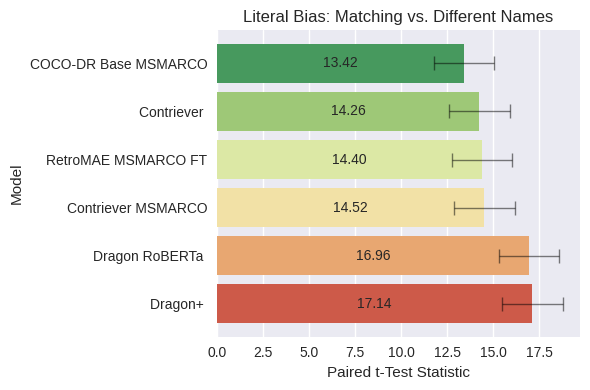

In [13]:
df = df_dot.copy()
print(plot_col_dots)

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_query")[0] and query_model == col2.split("_query")[0] and col1 != col2 and "query_short_namegold_doc_short" in col1:
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                    "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "mean_diff": (df[col1] - df[col2]).mean(),
                    "std_diff": (df[col1] - df[col2]).std(),
                    "n": len(df),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)
plt.figure(figsize=(6, 4))
plt.title("Literal Bias: Matching vs. Different Names")
ax = sns.barplot(data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn_r"), hue="Model")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
results_df.to_json("results/literal_df.json", orient="records")
# ax.bar_label(ax.containers[0], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')
# ax.bar_label(ax.containers[1], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')

plt.tight_layout()
plt.savefig("figs/literal_ttest.pdf")
results_df